In [128]:
from sympy import *
init_printing()

In [129]:
import pandas as pd

# File paths
file_path_bygholm = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Data/Nedbor_Dag_Bygholm Skov_DMI.csv"
file_path_hesselballe = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Data/Nedbor_Dag_Hesselballe_DMI.csv"
file_path_korup_parken = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Data/Bygholm_Kørup_Parken_VNF_døgn_1975-2023.csv"

# Read CSVs with correct delimiter and skip headers
bygholm_df = pd.read_csv(file_path_bygholm, skiprows=13, encoding="ISO-8859-1", delimiter=";")
hesselballe_df = pd.read_csv(file_path_hesselballe, skiprows=13, encoding="ISO-8859-1", delimiter=";")
korup_parken_df = pd.read_csv(file_path_korup_parken, decimal=",", encoding="ISO-8859-1", delimiter=";")

# Clean column names (remove leading spaces)
bygholm_df.columns = bygholm_df.columns.str.strip()
hesselballe_df.columns = hesselballe_df.columns.str.strip()
korup_parken_df.columns = korup_parken_df.columns.str.strip()

# Rename columns to match R
bygholm_df.columns = ["timestamp", "NedbørByg", "ksMRK"]
hesselballe_df.columns = ["timestamp", "NedbørHessel", "ksMRK"]
korup_parken_df.columns = ["timestamp", "KarupBro", "BygholmPark"]

# Convert timestamp to datetime format
bygholm_df["timestamp"] = pd.to_datetime(bygholm_df["timestamp"], format="%d-%m-%Y")
hesselballe_df["timestamp"] = pd.to_datetime(hesselballe_df["timestamp"], format="%d-%m-%Y")
korup_parken_df["timestamp"] = pd.to_datetime(korup_parken_df["timestamp"], format="%d-%m-%Y")

# Merge datasets on timestamp (left join)
merged_df = korup_parken_df.copy()
merged_df = merged_df.merge(bygholm_df[["timestamp", "NedbørByg"]], on="timestamp", how="left")
merged_df = merged_df.merge(hesselballe_df[["timestamp", "NedbørHessel"]], on="timestamp", how="left")

# Drop the BygholmPark column if it's not needed
merged_df = merged_df.drop(columns=["BygholmPark"])

# Remove rows where NedbørByg or NedbørHessel is missing
merged_df = merged_df.dropna(subset=["NedbørByg", "NedbørHessel"])

# Create a sequential Time index
merged_df["Time"] = range(len(merged_df))

# reset index
merged_df = merged_df.reset_index(drop=True)

# Display the cleaned and merged dataset
print(shape(merged_df))
merged_df.head()

(5110, 5)


,timestamp,KarupBro,NedbørByg,NedbørHessel,Time
0,2010-01-04,1806.75,0.2,0.2,0
1,2010-01-05,1676.60,0.6,0.5,1
2,2010-01-06,1562.37,0.3,0.2,2
3,2010-01-07,1427.74,0.0,0.1,3
4,2010-01-08,1280.80,0.0,0.0,4


In [130]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define input features (predictors)
X = merged_df[["NedbørByg", "NedbørHessel"]]

# Define target variable (water level)
y = merged_df["KarupBro"]

## Adding lag feature

In [131]:
# Add previous day's inflow as a new feature
merged_df["KarupBro_Lag1"] = merged_df["KarupBro"].shift(1)

# Drop NaN rows caused by shifting
merged_df = merged_df.dropna()

# Update feature set
X = merged_df[["NedbørByg", "NedbørHessel", "KarupBro_Lag1"]]
y = merged_df["KarupBro"]
merged_df.head()

,timestamp,KarupBro,NedbørByg,NedbørHessel,Time,KarupBro_Lag1
1,2010-01-05,1676.60,0.6,0.5,1,1806.75
2,2010-01-06,1562.37,0.3,0.2,2,1676.60
3,2010-01-07,1427.74,0.0,0.1,3,1562.37
4,2010-01-08,1280.80,0.0,0.0,4,1427.74
5,2010-01-09,1169.95,0.0,0.0,5,1280.80


In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [133]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [134]:
y_test.head() , y_train.tail()

(4088    5512.87
 4089    4531.11
 4090    3501.46
 4091    2833.36
 4092    2335.32
 Name: KarupBro, dtype: float64,
 4083     832.00
 4084    3217.89
 4085    5620.73
 4086    4994.59
 4087    6097.29
 Name: KarupBro, dtype: float64)

In [135]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Print model coefficients
print("Model Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Model Coefficients: [ 5.93420665 33.57966688  0.93303805]
Intercept: 31.79385030892945


In [136]:
# Predict on test data
y_pred = model.predict(X_test)

# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
r2 = model.score(X_test, y_test)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.3f}")


Mean Absolute Error (MAE): 226.59
Root Mean Squared Error (RMSE): 413.45
Mean Squared Error (MSE): 170942.13
R² Score: 0.946


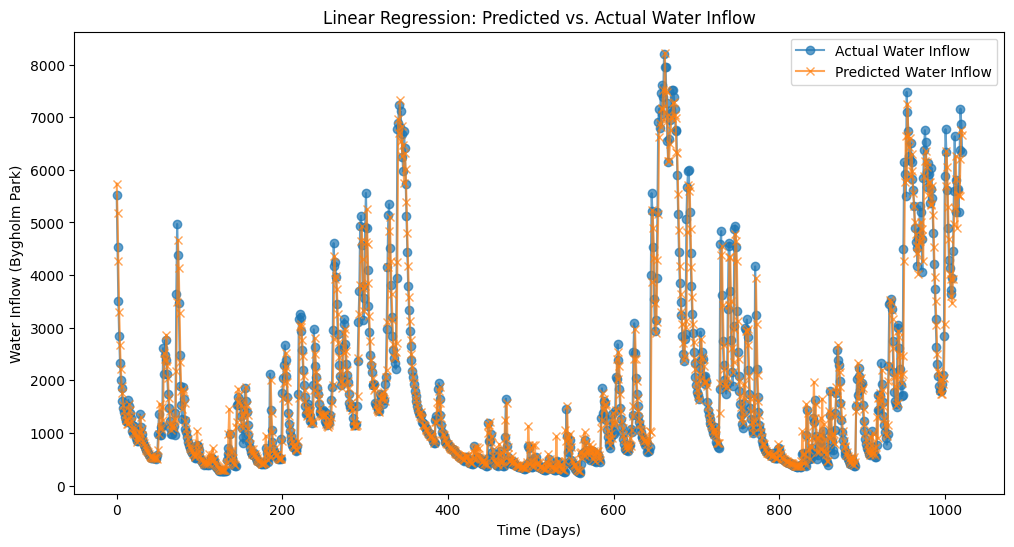

In [137]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual Water Inflow", linestyle="-", marker="o", alpha=0.7)
plt.plot(y_pred, label="Predicted Water Inflow", linestyle="-", marker="x", alpha=0.7)
plt.legend()
plt.xlabel("Time (Days)")
plt.ylabel("Water Inflow (Bygholm Park)")
plt.title("Linear Regression: Predicted vs. Actual Water Inflow")
plt.show()


               NedbørByg  NedbørHessel  KarupBro  KarupBro_Lag1
NedbørByg       1.000000      0.617151  0.110151       0.032199
NedbørHessel    0.617151      1.000000  0.180363       0.079572
KarupBro        0.110151      0.180363  1.000000       0.944492
KarupBro_Lag1   0.032199      0.079572  0.944492       1.000000


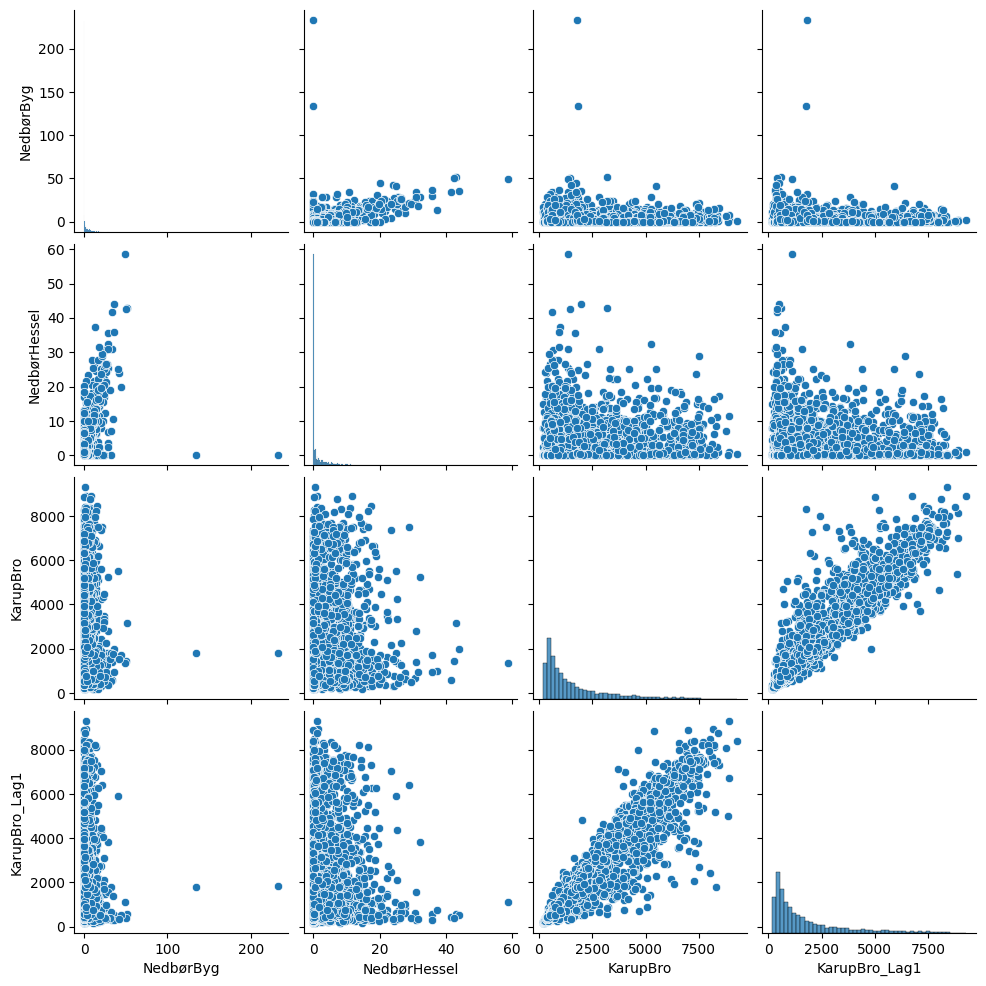

In [138]:
import seaborn as sns

correlation_matrix = merged_df[["NedbørByg", "NedbørHessel", "KarupBro", "KarupBro_Lag1"]].corr()
print(correlation_matrix)

sns.pairplot(merged_df[["NedbørByg", "NedbørHessel", "KarupBro", "KarupBro_Lag1"]])
plt.show()